Dalla libreria sklearn è possibile anche importare un comando che suddivide il dominio in training set e test set seguendo una precisa proporzione fornita come argomento: <br>
<code> 
from sklearn.model_selection import train_test_split <br>
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
</code>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import random 
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron

In [2]:
IDnumber = 2025168
#YOUR_ID , try also to change the seed to see the impact of random initialization on the results
np.random.seed(IDnumber)

#load the dataset
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = np.array(list(NBA)).astype(int)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels
# first coloumn are already the labels, 1 if it's a center, 0 if point guard. We can shift the labels to get {-1,1} doubling the label and subtracting one  

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0] # it returns the dimension of our domain set 
print(m)
permutation = np.random.permutation(m) # random permurtation of data mixing them inside the arrays. It returns an array of numbers from 0 to 259 (indices of data) to use as a mask to rearrange the aforementioned arrays

X = X[permutation]
Y = Y[permutation]

m_training = (7*m)//10 # choosing the training set to contain 70% of the actual data. Se il settanta percento non è un numero intero decido di usare la divisione intera, approsismando così per difetto la percentuale di dati nel training set

#m_test needs to be the number of samples in the test set
m_test = m-m_training

#X_training = instances for training set
# posso costruire un array di sette numeri da 0 a m-1 (corrispondenti alle righe). Una combinazione cioè di m numeri in m_training classi senza ripetizione. In questo modo potrò usare la mask random.sample(range(m),m_training) (che è già la lista con m_training elementi presi senza ripetizione dal range(m)) applicarla a X e trovare così il training set
mask_training = random.sample(range(m),m_training)
X_training = X[mask_training]
Y_training = Y[mask_training]
# devo controllare se in Y_training ci sono almeno dieci -1 e almeno dieci 1
minus = 0
plus = 0
for num in Y_training :
    if num == 1 :
        plus += 1 
    else :
        minus +=1
if plus >10 and minus > 10 : print("There are at least ten -1 and ten 1 in Y_training")
else : print("modify permutation or apply it multiple times")

# in questi posso mettere tutte le righe che non sono in x_training. Creo la maschera contenente tutti quegli indici che non si trovano in mask training tramite list comprehension 
mask_test = [num for num in permutation if num not in mask_training]
X_test = X[mask_test]
Y_test = Y[mask_test]
# per verificare che gli elementi di X_training non siano in X_test confronto le maschere tramite inter=np.intersect1d(np.array(mask_training),np.array(mask_test)). Questo array contiene gli elementi ottenuti dall'operazione di intersezione logica tra i due insiemi/array mask_training e mask_test. Cioè restituisce un array con quegli elementi in comune tra i due array. Se è vuoto allora l'operazione di costruzione dei due set è andata a buon fine
if np.intersect1d(np.array(mask_training),np.array(mask_test)).size == 0 : print("There are no conflicts between training and test set")

# print(Y_training) #to make sure that Y_training contains both 1 and -1
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))
print("Shape of training labels: " + str(Y_training.shape))
print("Shape of test labels: " + str(Y_test.shape))

#add a 1 to each sample (homogeneous coordinates)
# Definisico nuovi array altrimenti i precedenti ogni volta che eseguo il codice vengono aggionrati e vi si aggiunge una colonna in più ad ogni run
X_training_h = np.hstack((np.ones((m_training,1)),X_training))
X_test_h = np.hstack((np.ones((m_test,1)),X_test))
print("dimension of X in homogeneus coordinates is", np.shape(X_training_h))


['Position', 'Height cm', 'kg', 'Age']
260
There are at least ten -1 and ten 1 in Y_training
There are no conflicts between training and test set
78
Shape of training set: (182, 3)
Shape of test set: (78, 3)
Shape of training labels: (182,)
Shape of test labels: (78,)
dimension of X in homogeneus coordinates is (182, 4)


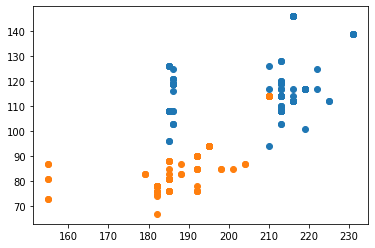

In [125]:
# rappresentiamo i punti per vedere se sono linearly separable o no 
x = X[:,0:2] 
# però definisco i punti che hanno -1 come label red e quelli che hanno uno blue
y = Y
x_blue1 = x[np.where(y == 1),0] 
x_blue2 = x[np.where(y == 1),1]
# questa qua dentro l'argomento di x è una mask che mi dice gli indici dove in y ci sono uno oppure meno uno
x_red1 = x[np.where(y == -1),0]
x_red2 = x[np.where(y == -1),1]
# devo rappresentare le due x 
plt.scatter(x_blue1,x_blue2)
plt.scatter(x_red1,x_red2)

Per avere un'idea sulla convergenza dell'algoritmo rappresento due delle features dei punti del dominio, coloro diversamente quei punti la cui label è diversa.
I dati non sono linearmente separabili quindi il perceptron non converge nemmeno dopo tantissime iterazioni.

In [126]:
def perceptron1(x,y,max_n_iter) :
    curr_w = np.zeros((len(x[0]),1)) 
    best_w = np.zeros((len(x[0]),1))
    num_samples = len(y)
    best_error = 1
    num_iter = 1
    Z = x*y.reshape((-1,1))
    a = (Z @ curr_w <= 0).reshape((-1,)) 
    num_misclassified = np.count_nonzero(a)
    index_misclassified = np.random.choice(np.arange(num_samples)[a])

    while((index_misclassified != -1) and (num_iter < max_n_iter)) : 
        curr_w += Z[index_misclassified].reshape((-1,1)) 
        num_iter += 1
        a = (Z @ curr_w <= 0).reshape((-1,))
        num_misclassified = np.count_nonzero(a)
        e = num_misclassified/num_samples
        if e < best_error :
            best_error = e
            best_w = curr_w
        if num_misclassified > 0 :
            index_misclassified = np.random.choice(np.arange(num_samples)[a]) 
        else :
            index_misclassified = -1

    return best_w.reshape((-1,)),best_error

In [127]:
# Nuovo perceptron perchè il precedente restituisce un errore del cinquanta percento. Poichè agisce ogni iterazione su tutti i dati è molto probabile che il lavoro che viene fatto per migliorare l'inclinazione della retta quando si trova un punto misclassified venga annullato dal successivo upgrade di w. Infatti visto che vengono comunque ciclati tutti i punti che sono misclassified il peso w ha la stessa probabilità di "migliorare" e di "peggiorare" in ciascuna iterazione (del ciclo while).
def perceptron2(X, Y, max_num_iterations):
    curr_w = np.zeros(shape = (max_num_iterations, np.shape(X)[1]))
    new_w = np.zeros(shape = (max_num_iterations+1, np.shape(X)[1])) 
    num_samples = np.shape(X)[0]  
    number_misclassified = [] 
    num_iter = 0 
    index_misclassified = 0
    while ((index_misclassified != -1) and (num_iter < max_num_iterations)):
        index_misclassified = -1
        curr_w[num_iter,:] = new_w[num_iter,:]
        indexes_list = [i for i in range(num_samples-1) if Y[i]*np.dot(curr_w[num_iter,:],X[i,:]) <= 0] 
        number_misclassified.append(len(indexes_list))
        index_misclass_random = random.choice(indexes_list) 
        new_w[num_iter+1,:] = curr_w[num_iter,:] + Y[index_misclass_random]*X[index_misclass_random,:]
        if len(indexes_list) != 0 : index_misclassified = 0
        num_iter += 1
    new_w = np.delete(new_w, (-1), axis = 0) 
    # perchè devo eliminare l'ultima riga di new_w ottenuta durante l'ultima iterazione che ha assegnato l'ultima posizione + 1 al vettore dei pesi 
    best_w = new_w[np.argmin(number_misclassified),:]
    best_error = min(number_misclassified)/num_samples
    return best_w, best_error 

##  Perceptron mentre lo stavo sviluppando 

```python
import random 
#print(X_training_h)
#print(Y_training)
max_num_iterations = 100
curr_w = np.zeros(shape = (max_num_iterations, np.shape(X_training_h)[1]))
new_w = np.zeros(shape = (max_num_iterations+1, np.shape(X_training_h)[1]))   
num_iter = 0
index_misclassified = 0
numeroerrori = []
while ((index_misclassified != -1) and (num_iter < max_num_iterations)) : 
    index_misclassified = -1
    curr_w[num_iter,:] = new_w[num_iter,:]
    listaindici = [i for i in range(np.shape(X_training_h)[0]-1) if (Y_training[i]*np.dot(curr_w[num_iter,:],X_training_h[i,:]) <= 0)] 
    numeroerrori.append(len(listaindici))
    # così ho trovato una lista contenente tutti i samples misclassified noto il vettore dei pesi per quell'iterazione naturalmente. La lunghezza di tale lista sono i samples misclassified e scegliendo uno degli indici a caso posso upgradare il vettore dei pesi con uno nuovo 
    indice_misclass_random = random.choice(listaindici) 
    # Scelto l'indice a caso utilizzo la riga di X e l'elemento di Y corrispondenti a tale indice per aggiornare il vettore dei pesi
    new_w[num_iter+1,:] = curr_w[num_iter,:] + Y_training[indice_misclass_random]*X_training_h[indice_misclass_random,:] # Aggiorno il peso 
    if len(listaindici) != 0 : index_misclassified = 0 # controllo se l'algoritmo è arrivato a convergere
    num_iter += 1
new_w = np.delete(new_w, (-1), axis = 0)
# a new_w devo eliminare l'ultima riga perchè è quella che corrisponde alla centesima iterazione che non ha ricevuto calcolo dell'errore in quanto il comando che appende l'errore si trova prima di quello che aggiorna il vettore dei pesi e arrivati a 100 new_w arriva alla riga 101 mentre l'errore non viene aggiornato più in quanto il while è interrotto

erroreminimo = min(numeroerrori)/np.shape(X_training_h)[0]
pesimigliori = new_w[np.argmin(numeroerrori),:]
print("l'errore minimo che è stato raggiunto durante l'algoritmo è: ", erroreminimo)
print("il miglior vettore dei pesi ottenuto è", pesimigliori)
```

Adesso devo utilizzare il vettore dei pesi w fornito dall'algoritmo per predire le labels dei punti appartenenti al test set: <br>
$y_i = \text{sign} (\langle \mathbf{w},\mathbf{x_i} \rangle + b)$ <br>
I pesi $ \mathbf{w}$ sono quelli ottenuti dal perceptron sul training set, predicendo quindi le labels del test set abbiamo già selezionato la best hypotesis e stiamo simulando l'algoritmo su dei dati "reali". L'errore che troviamo alla fine è una stima del true error in confronto al training error ottenuto dall'algoritmo sul set di allenamento.

In [136]:
w_found, error = perceptron2(X_training_h, Y_training, 100)
# ho constatato che comunque il vettore dei pesi trovato è sempre diverso al variare delle iterazioni
# print("Training error of perceptron is: ", error)
# I dati nel test set sono X_test_h in coordinate omogenee, di cui sono noti anche le labels pertanto possiamo fare un loop in cui confrontiamo per ogni label predetta quella teorica ed eventualmente incrementiamo un iterable che chiamiamo num_error
# num_error = 0
num_test_samples = np.shape(X_test_h)[0] # sono 78 in proporzione 30 percento su 260
num_training_samples = np.shape(X_training_h)[0]
print(num_test_samples)
print(w_found, error)

#num_error = 0 
Y_predict = [np.sign(np.dot(w_found,X_test_h[i,:])) for i in range(num_test_samples)]
num_error = np.count_nonzero(Y_test - Y_predict)
#for i in range(num_test_samples) :
    #y_predict = np.sign(np.dot(w_found,X_test_h[i,:]))
    #if y_predict != Y_test[i] :
        #num_error += 1
true_loss_estimate = num_error/num_test_samples
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate))

78
[  -5. -255.  555. -125.] 0.06593406593406594
Test Error of perceptron (100 iterations): 0.10256410256410256


# Logistic regression

In [45]:
# Provo ad usare la funzione che cito all'inzio del notebook per separare il dominio in training e test set
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

Qui è presente anche il modo in cui all'inizio del notebook abbiamo suddiviso il dominio in training set e test set. Volevo vedere se ci fossero differenze in termini di errori dell'algoritmo ma ho trovato gli stessi ordini di grandezza. <br>
```python
permutation = np.random.permutation(m) 
X = X[permutation] 
Y = Y[permutation] 
m_training = (7*m)//10 
m_test = m-m_training 
mask_training = random.sample(range(m),m_training) 
X_train = X[mask_training] 
Y_train = Y[mask_training] 
mask_test = [num for num in permutation if num not in mask_training] 
X_test = X[mask_test] 
Y_test = Y[mask_test] 
```

In [46]:
# Dalla stessa suddivisione in training set e test set utilizzo la logisitc regression per predire la binary classification dei giocatori di basket 
logreg = linear_model.LogisticRegression(C=1e5) # una grossa costante c implica il non considerare quasi la regolarizzazione
logreg.fit(X_train, Y_train) # in questo modo alleno l'algoritmo sui dati nel training set
Y_predict_training = logreg.predict(X_train)
misclass_training = 0 # inizializzo il numero di misclassified labels per incrementarlo ogni volta che la Y_predict è diversa da Y_training per ciascuna riga 
for i in range(num_training_samples-1) :
    if Y_predict_training[i] != Y_train[i] :
        misclass_training += 1
print("Error rate on training set is: ", misclass_training/num_training_samples) 

Y_predict_test = logreg.predict(X_test)
misclass_test = 0
# print(Y_predict_test,"\n", Y_test)
for i in range(num_test_samples-1) :
    if Y_predict_test[i] != Y_test[i] :
        misclass_test += 1
print("Error rate on test set is: ", misclass_test/num_test_samples)

Error rate on training set is:  0.07692307692307693
Error rate on test set is:  0.02564102564102564


Adesso posso restringere i dati a sole due features. Tra le tre a disposizione scelgo di escludere l'età in quanto non provvede una comprensione migliore del problema. Intuitivamnete infatti l'età dei giocatori non è correlata al loro ruolo e nemmeno dunque alle altre due features, non è dipendente dalle altre due bensì direttamente ininfluente.

In [47]:
#to make the plot we need to reduce the data to 2D, so we choose two features
from sklearn.model_selection import train_test_split

features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

# select a pair of features
index_feature1 = 0 # we choose height
index_feature2 = 1 # and weight (age of course is not very meaningful)
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

# suddivido nuovamene in training set e test set 

X_train2, X_test2, Y_train2 ,Y_test2 = train_test_split(X_reduced,Y,test_size=0.3,random_state=0)


In [48]:
# Adesso alleniamo l'algoritmo su questi dati 
logreg2 = linear_model.LogisticRegression(C=1e5) 
logreg2.fit(X_train2, Y_train2) 
Y_predict_training2 = logreg2.predict(X_train2)
misclass_training2 = 0  
for i in range(num_training_samples-1) :
    if Y_predict_training2[i] != Y_train2[i] :
        misclass_training2 += 1
print("Error rate on training set is: ", misclass_training2/num_training_samples) 

Y_predict_test2 = logreg2.predict(X_test2)
misclass_test2 = 0

for i in range(num_test_samples-1) :
    if Y_predict_test2[i] != Y_test2[i] :
        misclass_test2 += 1
print("Error rate on test set is: ", misclass_test2/num_test_samples)

Error rate on training set is:  0.07692307692307693
Error rate on test set is:  0.02564102564102564


## NON CAPISCO PERCHE' MA E' TROPPO PESANTE DA ESEGUIRE E PROVOCA ANCHE UN GROSSO RALLENTAMENTO NEL SALVATAGGIO DEL NOTEBOOK QUINDI NON ESEGUIRE!!!

```python


# proviamo a rappresentare i dati e i predict sulle due features che abbiamo scelto 
h = .1  # step size in the mesh HO DOVUTO CAMBIARLO DI UN ORDINE DI GRANDEZZA ALTRIMENTI VENIVA RESTITUITO UN ERRORE DI MEMORIA 
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=Y_train2, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test2[:, 0], X_test2[:, 1], c=Y_test2, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()
```

# Linear regression #
I dati presentano ben 500 osservazioni di cui 13 input per la regressione lineare e un output, la predizione, cioè il prezzo di una casa. Bisogna dunque costruire una linear regression in grado di correlare tra loro i tredici input e restituire il prezzo della casa noti dei dati già etichettati nel training set per allenare l'algoritmo.

The variable names are as follows:

CRIM: per capita crime rate by town.

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS: proportion of nonretail business acres per town.

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX: nitric oxides concentration (parts per 10 million).

RM: average number of rooms per dwelling.

AGE: proportion of owner-occupied units built prior to 1940.

DIS: weighted distances to five Boston employment centers.

RAD: index of accessibility to radial highways.

TAX: full-value property-tax rate per $10,000.

PTRATIO: pupil-teacher ratio by town.

B: 1000*(Bk – 0.63)2 where Bk is the proportion of blacks by town.

LSTAT: % lower status of the population.

MEDV: Median value of owner-occupied homes in $1000s

In [4]:
filename = "data/house.csv"
dataDescription = pd.read_csv(filename,delimiter = ";")
display(dataDescription)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,240
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,216
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,347
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,334
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.17899,0.0,9.69,0,0.585,5.670,28.8,2.7986,6,391,19.2,393.29,17.60,231
496,0.28960,0.0,9.69,0,0.585,5.390,72.9,2.7986,6,391,19.2,396.90,21.14,197
497,0.26838,0.0,9.69,0,0.585,5.794,70.6,2.8927,6,391,19.2,396.90,14.10,183
498,0.23912,0.0,9.69,0,0.585,6.019,65.3,2.4091,6,391,19.2,396.90,12.92,212


In [ ]:
# adesso voglio suddividere in training, validation e test set con proporzione 60,20,20 
